In [2]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [3]:
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [4]:
def lorenz(_: float, u: np.ndarray, sigma: float, rho: float,
           beta: float) -> np.ndarray:
    """Returns a list containing the three functions of the Lorenz equation.

    The Lorenz equations have constant coefficients (that don't depend on t),
    but we still receive t as the first parameter because that's how the
    integrator works.
    """
    x = u[0]
    y = u[1]
    z = u[2]
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    return np.hstack((dx_dt, dy_dt, dz_dt))

In [5]:
SIGMA = 10
RHO = 28
BETA = 8 / 3
t0 = 0.001
dt = 0.01
tmax = 200
n = int(tmax / dt)

u0 = np.array([-8, 8, 27])
t = np.linspace(start=t0, stop=tmax, num=n)
result = solve_ivp(fun=lorenz,
                        t_span=(t0, tmax),
                        y0=u0,
                        t_eval=t,
                        args=(SIGMA, RHO, BETA))
u = result.y.T

In [6]:
u_torch = torch.tensor(u)
u_torch.shape

torch.Size([20000, 3])

Text(0, 0.5, 'z')

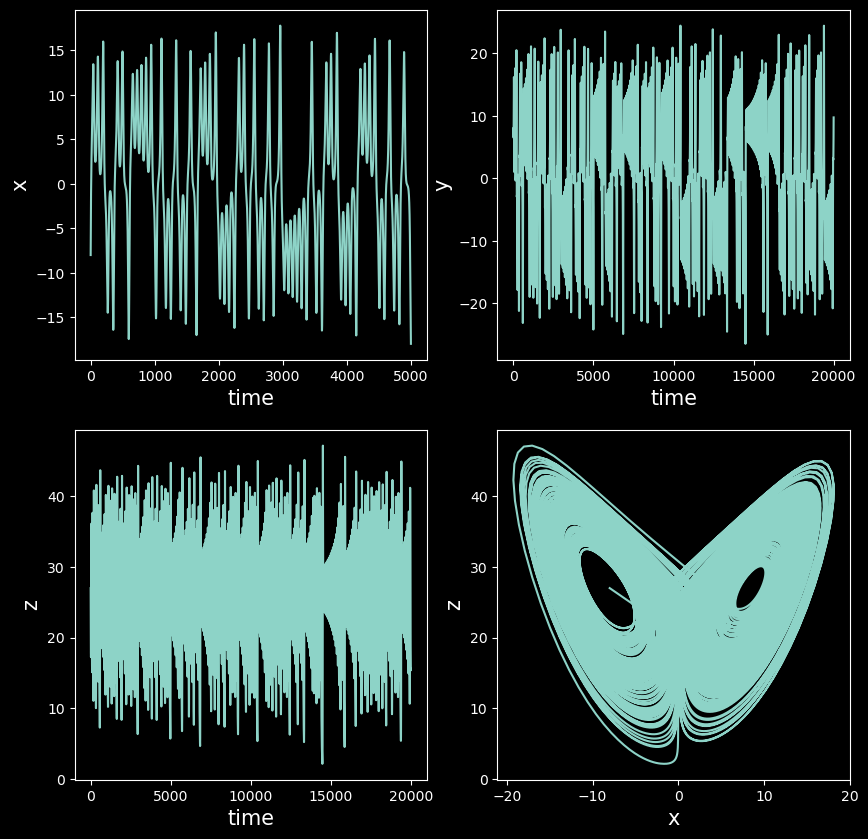

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(u_torch[0:5000,0])
axs[0,0].set_xlabel('time',fontsize=15)
axs[0,0].set_ylabel('x',fontsize=15)

axs[0,1].plot(u_torch[:,1])
axs[0,1].set_xlabel('time',fontsize=15)
axs[0,1].set_ylabel('y',fontsize=15)

axs[1,0].plot(u_torch[:,2])
axs[1,0].set_xlabel('time',fontsize=15)
axs[1,0].set_ylabel('z',fontsize=15)

axs[1,1].plot(u_torch[:,0],u_torch[:,2])
axs[1,1].set_xlabel('x',fontsize=15)
axs[1,1].set_ylabel('z',fontsize=15)



In [8]:
## Prepare train and test data ##
Ntrain = 10000
Ntest = 10000
lead=1
mean_data = torch.mean(u_torch.flatten())
std_data = torch.std(u_torch.flatten())

u_torch_norm = (u_torch-mean_data)/std_data

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

input_train_torch =u_torch_norm[0:Ntrain,:].float().to(device)
label_train_torch =u_torch_norm[lead:Ntrain+lead,:].float().to(device)

u_test_input = u_torch_norm[Ntrain+lead:Ntrain+lead+Ntest,:].float().to(device)
u_test_label = u_torch_norm[Ntrain+2*lead:Ntrain+2*lead+Ntest,:].float().to(device)

u_test_label_numpy = u_test_label.detach().cpu().numpy()

input_size = 3
output_size = 3
hidden_layer_size = 20

print('shape of training inputs',input_train_torch.shape)
print('shape of training labels',label_train_torch.shape)

print('shape of test inputs',u_test_input.shape)
print('shape of test labels',u_test_label.shape)


shape of training inputs torch.Size([10000, 3])
shape of training labels torch.Size([10000, 3])
shape of test inputs torch.Size([9999, 3])
shape of test labels torch.Size([9998, 3])


In [9]:
def directstep(net,input_batch):
  output_1 = net(input_batch.to(device))
  return output_1

In [10]:
time_step=dt
def RK4step(net,input_batch):
 output_1 = net(input_batch.to(device))
 output_2 = net(input_batch.to(device)+time_step*0.5*output_1)
 output_3 = net(input_batch.to(device)+time_step*0.5*output_2)
 output_4 = net(input_batch.to(device)+time_step*output_3)

 return input_batch.to(device) + time_step*(output_1+2*output_2+2*output_3+output_4)/6

In [11]:
time_step=dt
def Eulerstep(net,input_batch):
 output_1 = net(input_batch.to(device))
 return input_batch.to(device) + time_step*(output_1)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = ((nn.Linear(input_size,hidden_layer_size)))
        torch.nn.init.xavier_uniform_(self.il.weight)

        self.hidden1  = ((nn.Linear(hidden_layer_size,hidden_layer_size)))
        torch.nn.init.xavier_uniform_(self.hidden1.weight)

        self.hidden2  = (nn.Linear(hidden_layer_size,hidden_layer_size))
        torch.nn.init.xavier_uniform_(self.hidden2.weight)

        self.hidden3  = (nn.Linear(hidden_layer_size,hidden_layer_size))
        torch.nn.init.xavier_uniform_(self.hidden3.weight)

        self.hidden4  = (nn.Linear(hidden_layer_size,hidden_layer_size))
        torch.nn.init.xavier_uniform_(self.hidden4.weight)

        self.hidden5  = (nn.Linear(hidden_layer_size,hidden_layer_size))
        torch.nn.init.xavier_uniform_(self.hidden5.weight)

        self.ol  = nn.Linear(hidden_layer_size,output_size)
        torch.nn.init.xavier_uniform_(self.ol.weight)

        self.tanh = nn.Tanh()

    def forward(self,x):

        x1 = self.tanh(self.il(x))
        x2 = self.tanh(self.hidden1(x1))
        x3 = self.tanh(self.hidden2(x2))
        x4 = self.tanh(self.hidden3(x3))
        x5 = self.tanh(self.hidden4(x4))
        x6 = self.tanh(self.hidden5(x5))
        out =self.ol(x6)
        return out

In [13]:
mynet = Net()
count_parameters(mynet)
mynet.to(device)
epochs = 100
loss_fn = nn.MSELoss()
optimizer = optim.Adam(mynet.parameters(), lr=0.005)

loss_fn = nn.MSELoss()
batch_size=100


Loss = np.zeros([epochs+1])
for ep in range(0, epochs+1):
      print('Epoch', ep)
      for step in range(0,Ntrain,batch_size):
        indices = np.random.permutation(np.arange(start=step, step=1,stop=step+batch_size))
        input_batch, label_batch = input_train_torch[indices].float().to(device), label_train_torch[indices].float().to(device)
        optimizer.zero_grad()
        outputs = directstep(mynet,input_batch)
        loss = loss_fn(outputs,label_batch)

        loss.backward(retain_graph=True)
        optimizer.step()
        if step % 1000 == 0:
          print('step',step)

      print ('Loss', loss)
      Loss[ep] = loss.detach().cpu().numpy()

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
|   il.weight    |     60     |
|    il.bias     |     20     |
| hidden1.weight |    400     |
|  hidden1.bias  |     20     |
| hidden2.weight |    400     |
|  hidden2.bias  |     20     |
| hidden3.weight |    400     |
|  hidden3.bias  |     20     |
| hidden4.weight |    400     |
|  hidden4.bias  |     20     |
| hidden5.weight |    400     |
|  hidden5.bias  |     20     |
|   ol.weight    |     60     |
|    ol.bias     |     3      |
+----------------+------------+
Total Trainable Params: 2243
Epoch 0
step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000
Loss tensor(0.0155, device='mps:0', grad_fn=<MseLossBackward0>)
Epoch 1
step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000
Loss tensor(0.0040, device='mps:0', grad_fn=<MseLossBackward0>)
Epoch 2
step 0
step 1000
step 2000
step 3000
step 4000
st

Text(0, 0.5, 'Loss')

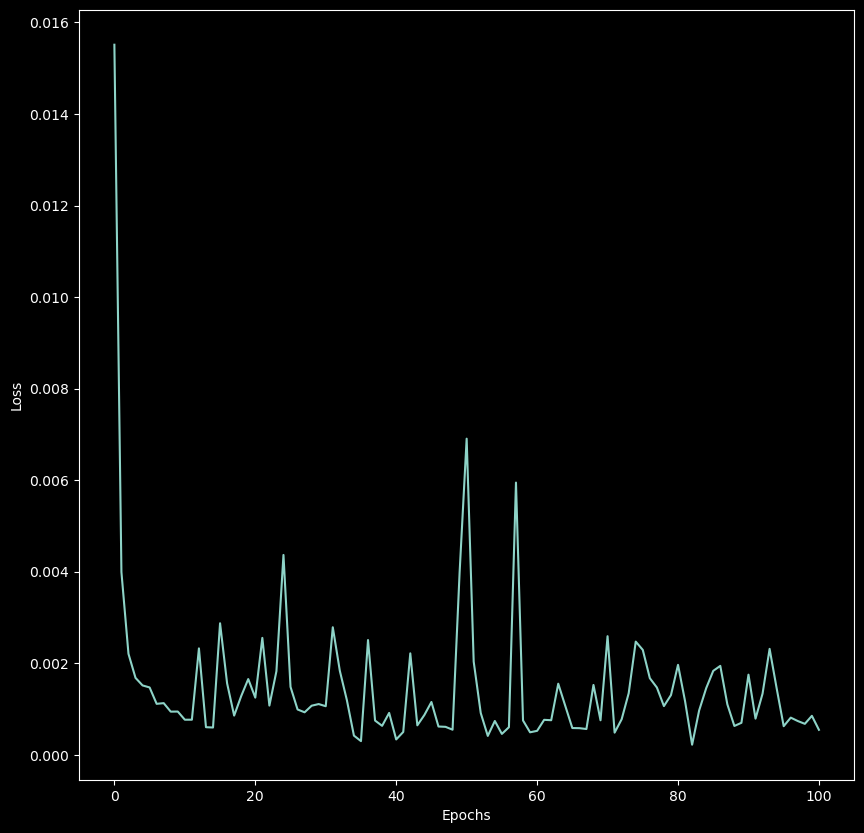

In [14]:
plt.plot(Loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [15]:
dim=3
M=Ntest
pred = np.zeros([M,dim])
for k in range(0,M):

    if (k==0):

        out = directstep(mynet,u_test_input[0,:].reshape([1,dim]))
        pred [k,:] = out.detach().cpu().numpy()

    else:

        out = directstep(mynet,torch.from_numpy(pred[k-1,:].reshape([1,dim])).float().to(device))

        pred [k,:] = out.detach().cpu().numpy()

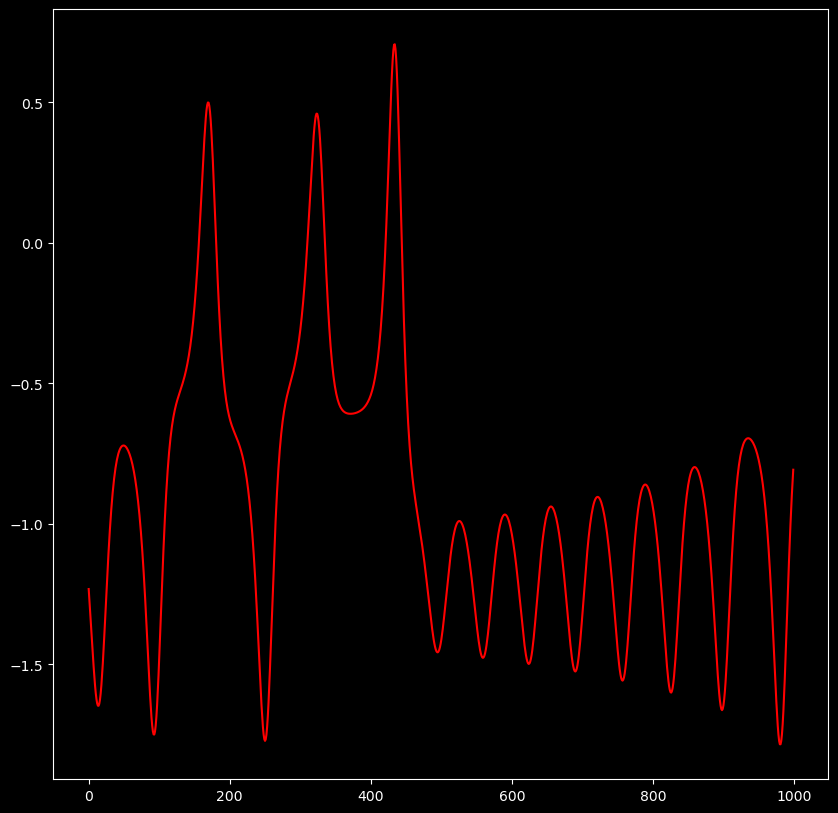

In [16]:
plt.plot(pred[0:1000,0],'k')
plt.plot(u_test_label_numpy[0:1000,0],'r')

Text(0, 0.5, 'z')

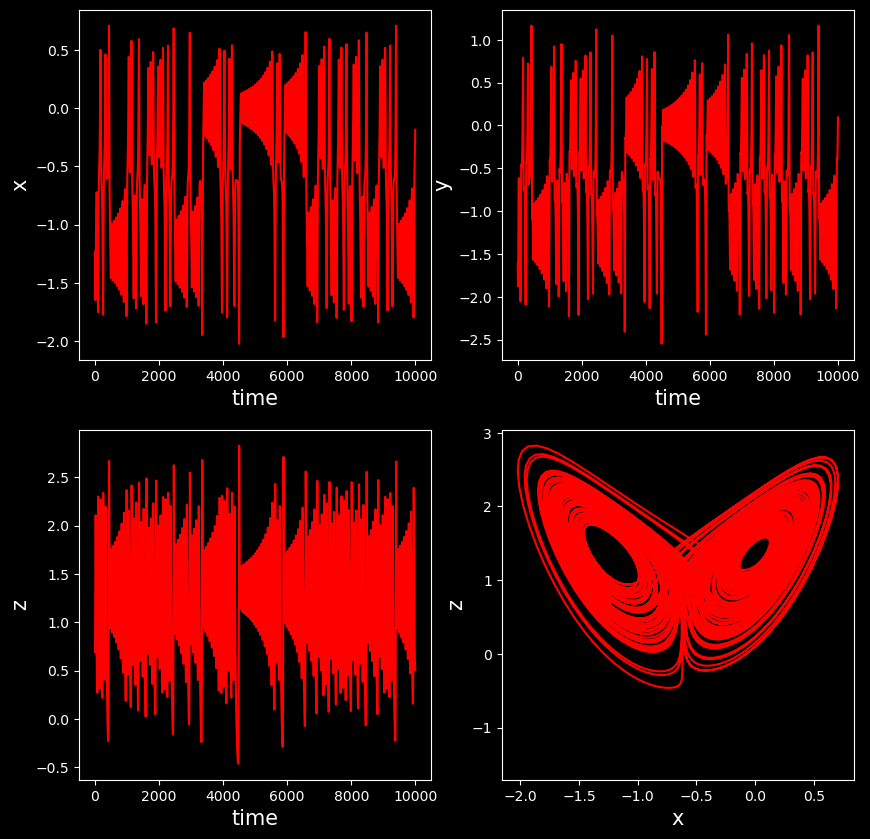

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(pred[:,0],'k')
axs[0,0].plot(u_test_label_numpy[:,0],'r')
axs[0,0].set_xlabel('time',fontsize=15)
axs[0,0].set_ylabel('x',fontsize=15)

axs[0,1].plot(pred[:,1],'k')
axs[0,1].plot(u_test_label_numpy[:,1],'r')
axs[0,1].set_xlabel('time',fontsize=15)
axs[0,1].set_ylabel('y',fontsize=15)

axs[1,0].plot(pred[:,2],'k')
axs[1,0].plot(u_test_label_numpy[:,2],'r')
axs[1,0].set_xlabel('time',fontsize=15)
axs[1,0].set_ylabel('z',fontsize=15)

axs[1,1].plot(pred[:,0],pred[:,0],'k')
axs[1,1].plot(u_test_label_numpy[:,0],u_test_label_numpy[:,2],'r')
axs[1,1].set_xlabel('x',fontsize=15)
axs[1,1].set_ylabel('z',fontsize=15)